In [1]:
from os import listdir
from matplotlib import image
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F

from __future__ import print_function
import argparse
import numpy  as np
from PIL import Image
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split

import numpy as np
import skimage
from skimage import data
import matplotlib.pyplot as plt  

In [34]:

# Network architecture.
class Deep_Emotion(nn.Module):
    def __init__(self):
        '''
        Deep_Emotion class contains the network architecture.
        '''
        super(Deep_Emotion,self).__init__()
        self.conv1 = nn.Conv2d(1,10,5)
        self.conv2 = nn.Conv2d(10,10,5)
        self.pool2 = nn.MaxPool2d(2,2)
        
        self.conv3 = nn.Conv2d(10,10,5)
        self.conv4 = nn.Conv2d(10,10,5)
        self.pool4 = nn.MaxPool2d(2,2)

        self.norm = nn.BatchNorm2d(10)

        self.fc1 = nn.Linear(320,50)
        self.fc2 = nn.Linear(50,8)
        
        self.dropout = nn.Dropout(0.3)
        
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),    #//////640
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)      #//////640///10*3*3
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        
        print(x.size(),"SIZE")
        print(theta.size(),"SIZE")
        
        grid = F.affine_grid(theta, x.size(),align_corners=True)
        x = F.grid_sample(x, grid)
        return x
#         return grid

    def forward(self,input):
#         grid = self.stn(input)
        out = self.stn(input)
        
#         out = F.relu(self.conv1(input))
        out = F.relu(self.conv1(out))
        out = self.conv2(out)
        out = F.relu(self.pool2(out))
        
        out = F.relu(self.conv3(out))
        out = self.norm(self.conv4(out))
        out = F.relu(self.pool4(out))

        out = self.dropout(out)
        
        out = out.view(-1, 320)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)

        return out
print("finish")

finish


In [41]:
class Deep_Emotion(nn.Module):
    def __init__(self):
        super(Deep_Emotion, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 8)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [42]:
class sec_Deep_Emotion(nn.Module):
    def __init__(self):
        super(Deep_Emotion, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.cnn3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.cnn4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.cnn5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.cnn6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.cnn7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.cnn1_bn = nn.BatchNorm2d(8)
        self.cnn2_bn = nn.BatchNorm2d(16)
        self.cnn3_bn = nn.BatchNorm2d(32)
        self.cnn4_bn = nn.BatchNorm2d(64)
        self.cnn5_bn = nn.BatchNorm2d(128)
        self.cnn6_bn = nn.BatchNorm2d(256)
        self.cnn7_bn = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 7)
        self.dropout = nn.Dropout(0.3)
#         self.log_softmax = nn.LogSoftmax(dim=1)
    def forward(self, x):
        x = self.relu(self.pool1(self.cnn1_bn(self.cnn1(x))))
        x = self.relu(self.pool1(self.cnn2_bn(self.dropout(self.cnn2(x)))))
        x = self.relu(self.pool1(self.cnn3_bn(self.cnn3(x))))
        x = self.relu(self.pool1(self.cnn4_bn(self.dropout(self.cnn4(x)))))
        x = self.relu(self.pool2(self.cnn5_bn(self.cnn5(x))))
        x = self.relu(self.pool2(self.cnn6_bn(self.dropout(self.cnn6(x)))))
        x = self.relu(self.pool2(self.cnn7_bn(self.dropout(self.cnn7(x)))))
    
        x = x.view(x.size(0), -1)
    
        x = self.relu(self.dropout(self.fc1(x)))
        x = self.relu(self.dropout(self.fc2(x)))
        x = self.fc3(x)
#         x = self.log_softmax(self.fc3(x))
        return x

In [45]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
def Train(epochs,train_loader,val_loader,criterion,optmizer,device):
    '''
    Training Loop
    '''
    print("===================================Start Training===================================")
#     validation_dataset = 0
#     test_dataset = 0
    traini_loss = list()
    vali_loss = list()
    
    traini_acc = list()
    vali_acc = list()
    
    for e in range(epochs):
        train_loss = 0
        validation_loss = 0
        train_correct = 0
        val_correct = 0
        
        # Train the model  #
        net.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optmizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs,labels)
            loss.backward()
            optmizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs,1)
            train_correct += torch.sum(preds == labels.data)  #----------------------->
#             train_dataset = train_dataset+1
#         scheduler.step()

        #validate the model#
        net.eval()
        for data,labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            val_outputs = net(data)
            val_loss = criterion(val_outputs, labels)
            validation_loss += val_loss.item()
            _, val_preds = torch.max(val_outputs,1)
            val_correct += torch.sum(val_preds == labels.data) #----------------------->
#             validation_dataset = validation_dataset+1

#         print(len(train_dataset))
    
        train_loss = train_loss/len(train_loader.dataset)
        train_acc = train_correct.double() / len(train_loader.dataset)
        validation_loss =  validation_loss / len(val_loader.dataset)
        val_acc = val_correct.double() / len(val_loader.dataset)
        
        traini_loss.append(train_loss)
        vali_loss.append(validation_loss)
        
        traini_acc.append(train_acc)
        vali_acc.append(val_acc)
        
        print('Epoch: {} \tTraining Loss: {:.8f} \tValidation Loss {:.8f} \tTraining Acuuarcy {:.3f}% \tValidation Acuuarcy {:.3f}%'
                                                           .format(e+1, train_loss,val_loss,train_acc * 100, val_acc*100))

    torch.save(net.state_dict(),'deep_emotion_CK+neutral-30.30-{}-{}-{}.pt'.format(epochs,batchsize,lr))
    #-------------------------------------------->
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 6))
    plt.plot(range(0,len(traini_loss)),traini_loss, color='Blue', label='train')
    plt.plot(range(0,len(vali_loss)),vali_loss, color='Red', label='validation')
#     plt.plot(range(0,len(traini_acc)),traini_loss, color='cyan', label='train')
#     plt.plot(range(0,len(vali_acc)),vali_loss, color='yellow', label='validation')
    plt.legend() 
    plt.show() 
    print("===================================Training Finished===================================")


1097
[767, 111, 219]
===================================Start Training===================================
Epoch: 1 	Training Loss: 0.03249955 	Validation Loss 2.07652545 	Training Acuuarcy 11.213% 	Validation Acuuarcy 18.018%
Epoch: 2 	Training Loss: 0.03191719 	Validation Loss 2.03460860 	Training Acuuarcy 19.817% 	Validation Acuuarcy 19.820%
Epoch: 3 	Training Loss: 0.03141781 	Validation Loss 1.98827815 	Training Acuuarcy 22.425% 	Validation Acuuarcy 21.622%
Epoch: 4 	Training Loss: 0.03121353 	Validation Loss 2.05647969 	Training Acuuarcy 22.555% 	Validation Acuuarcy 20.721%
Epoch: 5 	Training Loss: 0.03092183 	Validation Loss 1.97100711 	Training Acuuarcy 24.772% 	Validation Acuuarcy 20.721%
Epoch: 6 	Training Loss: 0.03073991 	Validation Loss 1.98886108 	Training Acuuarcy 22.295% 	Validation Acuuarcy 20.721%
Epoch: 7 	Training Loss: 0.03049238 	Validation Loss 1.96601772 	Training Acuuarcy 23.859% 	Validation Acuuarcy 20.721%
Epoch: 8 	Training Loss: 0.03039889 	Validation Loss 2

Epoch: 68 	Training Loss: 0.00915619 	Validation Loss 0.64239573 	Training Acuuarcy 79.400% 	Validation Acuuarcy 81.982%
Epoch: 69 	Training Loss: 0.00889052 	Validation Loss 0.47392729 	Training Acuuarcy 79.531% 	Validation Acuuarcy 86.486%
Epoch: 70 	Training Loss: 0.00957250 	Validation Loss 0.44826487 	Training Acuuarcy 77.705% 	Validation Acuuarcy 87.387%
Epoch: 71 	Training Loss: 0.00892692 	Validation Loss 0.55429792 	Training Acuuarcy 80.052% 	Validation Acuuarcy 81.081%
Epoch: 72 	Training Loss: 0.00809686 	Validation Loss 0.41085970 	Training Acuuarcy 80.574% 	Validation Acuuarcy 83.784%
Epoch: 73 	Training Loss: 0.00780596 	Validation Loss 0.30097437 	Training Acuuarcy 81.486% 	Validation Acuuarcy 87.387%
Epoch: 74 	Training Loss: 0.00857739 	Validation Loss 0.39742416 	Training Acuuarcy 80.313% 	Validation Acuuarcy 86.486%
Epoch: 75 	Training Loss: 0.00749831 	Validation Loss 0.33639270 	Training Acuuarcy 83.051% 	Validation Acuuarcy 85.586%
Epoch: 76 	Training Loss: 0.0071

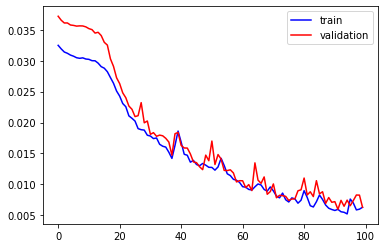

===================================Training Finished===================================


In [46]:
epochs = 100
lr = 0.005 #1-e3
batchsize = 64 #----------------------->
net = Deep_Emotion()
net.to(device)
# print("Model archticture: ", net)

transformation= transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,)),
                                    transforms.Grayscale(1),transforms.Resize((28,28))])
        
dataset = datasets.ImageFolder('C:/Users/nourg/Desktop/4th Year/GP/archive/CK+48', transform=transformation)
# Val_dataset = datasets.ImageFolder('C:/Users/nourg/Desktop/4th Year/GP/archive/ck+', transform=transformation)
# test_set = datasets.ImageFolder('C:/Users/nourg/Desktop/4th Year/GP/fer/data/test', transform=transformation)

lengths = [int(len(dataset)*0.7), int(len(dataset) - (int(len(dataset)*0.7)+int(len(dataset)*0.2))),int(len(dataset)*0.2)]
# lengths = [int(len(dataset)*0.8), int(len(dataset) - int(len(dataset)*0.8))]
print(len(dataset))
print(lengths)

train_set, Val_set, test_set = random_split(dataset, lengths, generator=torch.Generator().manual_seed(42))
# train_loader, Val_dataset= random_split(dataset, lengths, generator=torch.Generator().manual_seed(42))
    
train_loader = DataLoader(train_set, batch_size=batchsize,shuffle = True,num_workers=0)
val_loader = DataLoader(Val_set, batch_size=batchsize,shuffle = True,num_workers=0)
        
criterion= nn.CrossEntropyLoss()
# optmizer= optim.Adam(net.parameters(),lr= lr)

optmizer = optim.SGD(net.parameters(), lr = lr, momentum=0.9,weight_decay = 1e-3)

        # Decay LR by a factor of 0.1 every 7 epochs
#         exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
        
Train(epochs, train_loader, val_loader, criterion, optmizer, device)
        

In [47]:

transformation= transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,)), transforms.Grayscale(1), 
                                            transforms.Resize((48,48))])
# test_dataset = datasets.ImageFolder('C:/Users/nourg/Desktop/4th Year/GP/testr', transform=transformation)
test_loader =  DataLoader(test_set,shuffle = True,num_workers=0)

# import cv2
# import os

# folder = 'C:/Users/nourg/Desktop/4th Year/GP/testr/anger'


# images = []
# for filename in os.listdir(folder):
#     img = cv2.imread(os.path.join(folder,filename))
#     if img is not None:
#         images.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))


net = Deep_Emotion()
# print("Deep Emotion:-", net)
net.load_state_dict(torch.load('C:/Users/nourg/deep_emotion_CK+neutral-30.30-100-64-0.005.pt'))
net.to(device)
net.eval()
#Model Evaluation on test data
classes = ('Angry','contempt' ,'Disgust', 'Fear', 'Happy', 'neutral','Sad', 'Surprise')
# total = 0
correct = 0
total = 0
with torch.no_grad():
    for data, labels in test_loader:
#     for data in torch.tensor(images):
        data,labels = data.to(device), labels.to(device)
        outputs = net(data)
        pred = F.softmax(outputs,dim=1)
        classs = torch.argmax(pred,1)
#         wrong = torch.where(classs != labels,torch.tensor([1.]).to("cpu").data,torch.tensor([0.]).to("cpu").data)
        correct += (classs == labels).sum().item()
        total += labels.size(0)
        
#         acc = torch.sum(correct)
#         total.append(correct)
#         print("acc",acc)
#         imshow(torchvision.utils.make_grid(data))
#         print('GroundTruth: ', ' '.join('%7s' % classes[labels[j]] for j in range(7)))
        
#         print('Predicted: ', ' '.join('%7s' % classes[classs]))
#         total += labels.size(0)
#             total.append(acc.item())
                    
print('Accuracy of the network on the test images: %d %%' % (100 * (correct / total)) )
# print('Accuracy of the network on the test images: %d %%' % (100 * np.mean(total/ len(test_loader.dataset))))

        

Accuracy of the network on the test images: 91 %


tensor([3., 5., 0., 5., 7., 5., 5., 5., 1., 5., 1., 5., 5., 6., 7., 5., 6., 5., 7., 7., 7., 3., 4., 3., 6., 3., 3., 1.,
        6., 5., 3., 7., 5., 7., 5., 6., 3., 0., 4., 4., 4., 0., 5., 5., 4., 3., 3., 1., 1., 4., 3., 7., 1., 5., 7., 6.,
        6., 7., 5., 3., 0., 7., 5., 3., 6., 5., 6., 4., 3., 1., 7., 1., 3., 0., 7., 3., 6., 1., 4., 5., 7., 3., 4., 3.,
        0., 2., 7., 3., 6., 7., 4., 5., 5., 2., 7., 4., 4., 7., 5., 0., 5., 7., 7., 5., 7., 5., 7., 2., 1., 7., 7., 0.,
        0., 4., 7., 0., 3., 7., 5., 7., 7., 7., 5., 7., 3., 5., 7., 1., 7., 5., 4., 1., 7., 2., 0., 6., 3., 3., 7., 3.,
        7., 4., 7., 0., 3., 3., 2., 7., 3., 4., 7., 3., 1., 1., 2., 5., 3., 3., 5., 7., 4., 0., 3., 5., 7., 7., 7., 1.,
        3., 7., 1., 5., 7., 0., 3., 1., 5., 3., 4., 7., 0., 6., 7., 1., 3., 1., 0., 7., 5., 0., 0., 5., 0., 3., 5., 2.,
        4., 0., 1., 7., 7., 3., 5., 1., 7., 6., 6., 5., 0., 3., 5., 5., 7., 5., 6., 6., 7., 1., 3.])
Confusion matrix, without normalization
[[18  2  1  0  0  0

<Figure size 3600x3600 with 0 Axes>

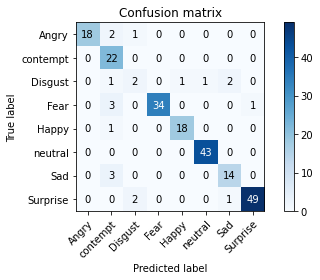

In [48]:

########################################################################################################
########################################CONFUSION MATRIX################################################
########################################################################################################

from __future__ import print_function
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
torch.set_printoptions(linewidth = 120)

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# classes = ('Angry','contempt' ,'Disgust', 'Fear', 'Happy','Sad', 'Surprise')
classes = ('Angry','contempt' ,'Disgust', 'Fear', 'Happy', 'neutral','Sad', 'Surprise')
# classes = ('Angry' ,'Disgust', 'Fear', 'Happy', 'neutral' , 'Sad', 'Surprise')
# dataset = datasets.ImageFolder('C:/Users/nourg/Desktop/4th Year/GP/archive2/images/train', transform=transformation)

net = Deep_Emotion()
# print("Deep Emotion:-", net)
net.load_state_dict(torch.load('C:/Users/nourg/deep_emotion_CK+neutral-30.30-100-64-0.005.pt'))
net.to(device)
net.eval()
# print(dataset.targets)

@torch.no_grad()
def get_all_prediction(model, loader):
    preds = torch.tensor([])
    label = torch.tensor([])
    for batch in loader:
        images, labels = batch
        batch_predictions = model(images)
        preds = torch.cat((preds, batch_predictions), dim = 0)
        label = torch.cat((label, labels), dim = 0)
    return preds,label


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

test_loader = DataLoader(test_set, batch_size=batchsize,shuffle = True,num_workers=0)
train_preds,label = get_all_prediction(net, test_loader)

# Plot non-normalized confusion matrix
# img , labels = test_loader
# train_features, train_labels = next(iter(test_loader))
# preds = torch.tensor([])
# for batch in loader:
#     images, labels = batch    
print(label)

plt.figure(figsize=(50,50))
plot_confusion_matrix(label, train_preds.argmax(dim=1), classes=classes,
                      title='Confusion matrix')

plt.show()

In [3]:
import cv2
emotion_dict = ('Angry','contempt' ,'Disgust', 'Fear', 'Happy','Sad', 'Surprise')

device = "cpu"
val_transform = transforms.Compose([
        transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
net = Deep_Emotion()
net.load_state_dict(torch.load('C:/Users/nourg/Desktop/4th Year/GP/archive/deep_emotion_ck+-100-64-0.005-97%.pt'))
net.to(device)
net.eval()
cap = cv2.VideoCapture(0)

count = 0

while True:
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    count +=1
    if True:
        face_cascade = cv2.CascadeClassifier('C:/Users/nourg/anaconda3/Library/etc/haarcascades/haarcascade_frontalface_default.xml')
        faces = face_cascade.detectMultiScale(frame)
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x,y), (x+w, y+h), (255,0,0), 2)
            resize_frame = cv2.resize(gray[y:y + h, x:x + w], (48, 48))
            X = resize_frame/256
#         cv2.imwrite("roi.jpg", X)
#         plt.imshow(X,'gray')
#         plt.show()
            X = Image.fromarray((X))
            X = val_transform(X).unsqueeze(0)
            with torch.no_grad():
                net.eval()
                out = net(X)
                pred = F.softmax(out,dim=1)
                classs = torch.argmax(pred,1)
                pred = emotion_dict[classs.item()]
            cv2.putText(frame, pred, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 1)
            count = 0
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

C:\Users\nourg\anaconda3\lib\site-packages\torchvision\transforms\functional.py:132: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
C:\Users\nourg\anaconda3\lib\site-packages\torch\nn\functional.py:3825: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [30]:
######################################################################################################################
######################################################################################################################
##############################################TRAAAAAAAAAAAASH########################################################
######################################################################################################################
######################################################################################################################
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from plotcm import plot_confusion_matrix
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_loader, batch_size=64)
    train_preds = get_all_preds(net, prediction_loader)
train_set.targets
train_preds.argmax(dim=1)

stacked = torch.stack(
    (
        train_set.targets
        ,train_preds.argmax(dim=1)
    )
    ,dim=1
)
cmt = torch.zeros(10,10, dtype=torch.int64)

for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1
    
cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, train_set.classes)

ModuleNotFoundError: No module named 'plotcm'

In [ ]:
# show images and labels in test set.
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
# Let us import the Libraries required.
import cv2
import numpy as np
import matplotlib.pyplot as plt

# from model import FacialExpressionModel

device = "cpu"
transformation= transforms.Compose([transforms.ToTensor()])
face_cascade = cv2.CascadeClassifier('C:/Users/nourg/anaconda3/Library/etc/haarcascades/haarcascade_frontalface_default.xml')
# To capture video from webcam.
cap = cv2.VideoCapture(0)
val_transform = transforms.Compose([
        transforms.ToTensor()])
net = Deep_Emotion()
net.load_state_dict(torch.load('C:/Users/nourg/Desktop/4th Year/GP/archive/deep_emotion_ck+-100-64-0.005-97%.pt'))
net.to(device)
net.eval()
#Model Evaluation on test data
classes = ('Angry', 'contempt' ,'Disgust', 'Fear', 'Happy','Sad', 'Surprise')
while True:
    # Read the frame
    _, img = cap.read()
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect the faces
    faces = face_cascade.detectMultiScale(img, 1.1, 4)
    # Draw the rectangle around each face
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2)
        resize_frame = cv2.resize(gray[y:y + h, x:x + w], (48, 48))
        
        X = resize_frame/256
        X = Image.fromarray((X))
        X = transformation(X).unsqueeze(0)
        
#         imge = torch.autograd.Variable(X,requires_grad = True)
#         plt.imshow('img', img)
#         plt.show()
        
        with torch.no_grad():
            
            imj = X.to(device)
            out = net(imj)
            pred = F.softmax(out,dim=1)
            classs = torch.argmax(pred,1)
#     wrong = torch.where(classs != 3,torch.tensor([1.]).cuda(),torch.tensor([0.]).cuda())
#     classs = torch.argmax(pred,1)
            prediction = classes[classs.item()]
            print(classs.item())
            font = cv2.FONT_HERSHEY_SIMPLEX
            org = (50, 50)
            fontScale = 1
            color = (255, 0, 0)
            thickness = 2
            img = cv2.putText(img, prediction, org, font,
                       fontScale, color, thickness, cv2.LINE_AA)
#         cv2.putText(img, pred, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 1)
        
#     imgg = load_img("C:/Users/nourg/roi.jpg")
    

    
    cv2.imshow('img', img)
    
    # Finding the Probability of each Emotion
#     preds = net.return_probabs(roi[np.newaxis, :, :, np.newaxis])

#         # Converting the array into list
#     data = preds.tolist()[0]

#         # Initializing the Figure for Bar Graph
#     fig = plt.figure(figsize=(8, 5))

#         # Creating the bar plot
#     plt.bar(EMOTIONS, data, color='green',
#                 width=0.4)

#         # Labelling the axes and title
#     plt.xlabel("Types of Emotions")
#     plt.ylabel("Probability")
#     plt.title("Facial Emotion Recognition")

#         # Saving the Bar Plot
#     path = "static/" + "bar_plot" + str(img)
#     plt.savefig(path)
        # Stop if (Q) key is pressed
        
    k = cv2.waitKey(30)
    if k==ord("q"):
        break

    # Release the VideoCapture object
cap.release()

C:\Users\nourg\anaconda3\lib\site-packages\torchvision\transforms\functional.py:132: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
C:\Users\nourg\anaconda3\lib\site-packages\torch\nn\functional.py:3825: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


1
5
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
6
6
6
5
1
6
6
6
6
1
1
6
6
6
6
6
6
6
6
6
6
6
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
6
1
1
1
1
1
1
1
1
1
1
1
1


In [ ]:
# Let us import the Libraries required.
import cv2
import numpy as np
import matplotlib.pyplot as plt

from model import FacialExpressionModel

# Creating an instance of the class with the parameters as model and its weights.
test_model = FacialExpressionModel("model.json", "model_weights.h5")

# Loading the classifier from the file.
facec = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


def Emotion_Analysis(img):
    """ It does prediction of Emotions found in the Image provided, does the 
    Graphical visualisation, saves as Images and returns them """

    # Read the Image through OpenCv's imread()
    path = "static/" + str(img)
    image = cv2.imread(path)

    # Convert the Image into Gray Scale
    gray_frame = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Image size is reduced by 30% at each image scale.
    scaleFactor = 1.3

    # 5 neighbors should be present for each rectangle to be retained.
    minNeighbors = 5

    # Detect the Faces in the given Image and store it in faces.
    faces = facec.detectMultiScale(gray_frame, scaleFactor, minNeighbors)

    # When Classifier could not detect any Face.
    if len(faces) == 0:
        return [img]

    for (x, y, w, h) in faces:

        # Taking the Face part in the Image as Region of Interest.
        roi = gray_frame[y:y+h, x:x+w]

        # Let us resize the Image accordingly to use pretrained model.
        roi = cv2.resize(roi, (48, 48))

        # Let us make the Prediction of Emotion present in the Image
        prediction = test_model.predict_emotion(
            roi[np.newaxis, :, :, np.newaxis])

        # Custom Symbols to print with text of emotion.
        Symbols = {"Happy": ":)", "Sad": ":}", "Surprise": "!!",
                   "Angry": "?", "Disgust": "#", "Neutral": ".", "Fear": "~"}
    

        ## based on the prediction recommend music


        # Defining the Parameters for putting Text on Image
        Text = str(prediction) + Symbols[str(prediction)]
        Text_Color = (180, 105, 255)

        Thickness = 2
        Font_Scale = 1
        Font_Type = cv2.FONT_HERSHEY_SIMPLEX

        # Inserting the Text on Image
        cv2.putText(image, Text, (x, y), Font_Type,
                    Font_Scale, Text_Color, Thickness)

        # Finding the Coordinates and Radius of Circle
        xc = int((x + x+w)/2)
        yc = int((y + y+h)/2)
        radius = int(w/2)

        # Drawing the Circle on the Image
        cv2.circle(image, (xc, yc), radius, (0, 255, 0), Thickness)

        # Saving the Predicted Image
        path = "static/" + "pred" + str(img)
        cv2.imwrite(path, image)

        # List of Emotions
        EMOTIONS = ["Angry", "Disgust",
                    "Fear", "Happy",
                    "Neutral", "Sad",
                    "Surprise"]

        # Finding the Probability of each Emotion
        preds = test_model.return_probabs(roi[np.newaxis, :, :, np.newaxis])

        # Converting the array into list
        data = preds.tolist()[0]

        # Initializing the Figure for Bar Graph
        fig = plt.figure(figsize=(8, 5))

        # Creating the bar plot
        plt.bar(EMOTIONS, data, color='green',
                width=0.4)

        # Labelling the axes and title
        plt.xlabel("Types of Emotions")
        plt.ylabel("Probability")
        plt.title("Facial Emotion Recognition")

        # Saving the Bar Plot
        path = "static/" + "bar_plot" + str(img)
        plt.savefig(path)
        
    # Returns a list containing the names of Original, Predicted, Bar Plot Images
    return ([img, "pred" + img, "bar_plot" + img, prediction])